# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

In [1]:
# install if not done yet
# !apt install libatlas-base-dev swig
# %pip install pypesto[amici,petab] --quiet

## The pipeline

First, we load the model and data to generate the MCMC samples from. Here, we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/multiple_conditions/conversion_reaction.yaml"
)
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Visualization table not available. Skipping.


Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [2]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [26]:
%%capture
result = sample.sample(
    problem,
    n_samples=10000,
    sampler=sampler,
    x0=np.array([3, -4]),
    filename=None,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

Elapsed time: 77.57845200000003


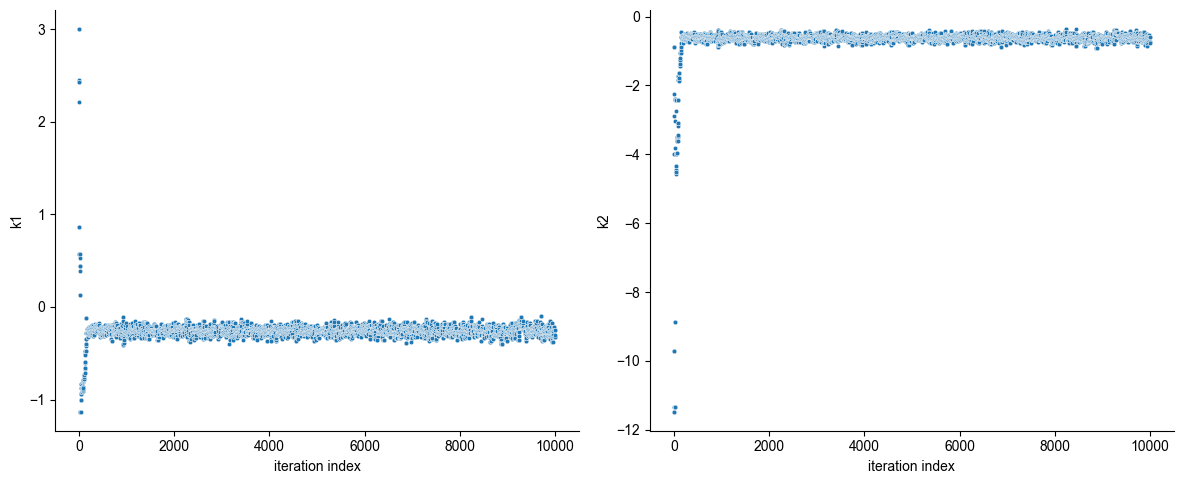

In [4]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke burn-in index: 500
Geweke burn-in index: 500


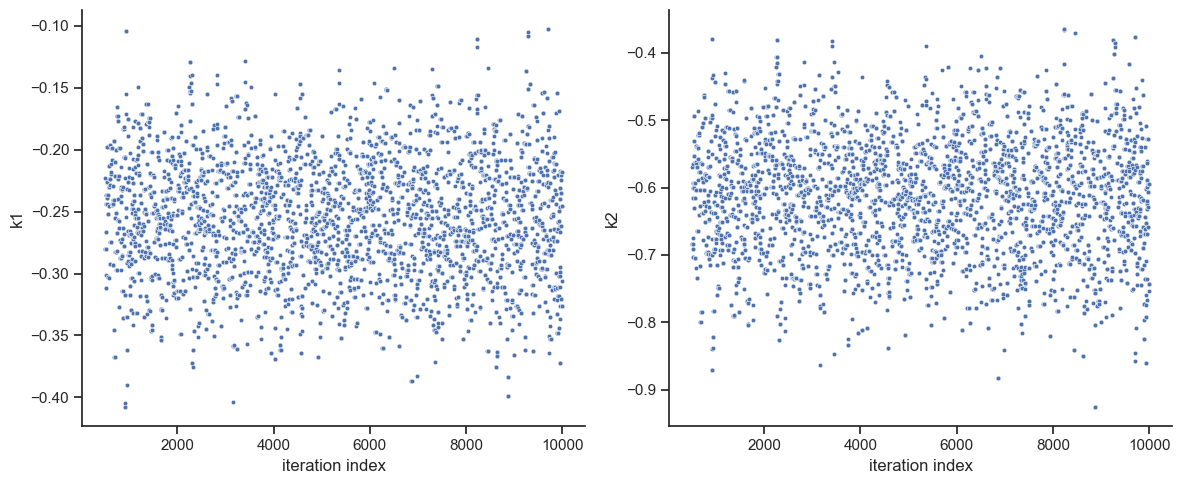

In [5]:
sample.geweke_test(result=result)
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

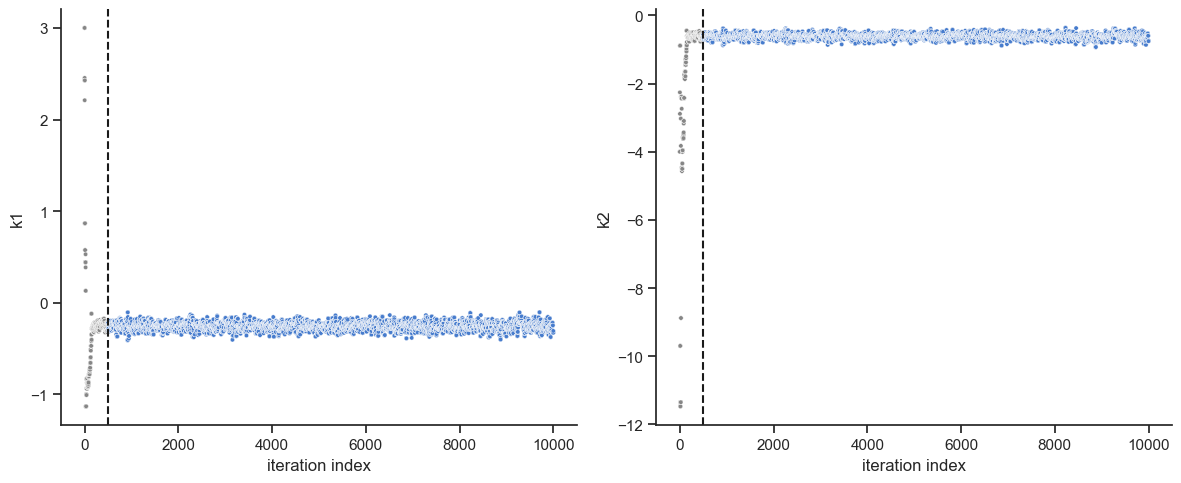

In [6]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, full_trace=True, size=(12, 5)
)

One can calculate the effective sample size per computation time. We save the results in a variable to compare them later.

In [7]:
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

Estimated chain autocorrelation: 8.33281897868538
Estimated chain autocorrelation: 8.33281897868538
Estimated effective sample size: 1018.0203882341143
Estimated effective sample size: 1018.0203882341143


Effective sample size per computation time: 5.99


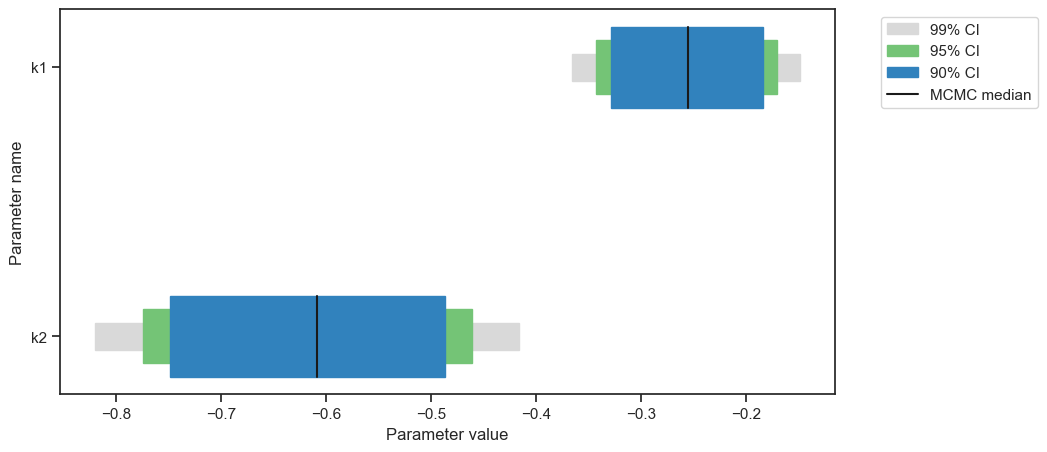

In [8]:
alpha = [99, 95, 90]
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(10, 5))

Predictions can be performed by creating a parameter ensemble from the sample, then applying a predictor to the ensemble. The predictor requires a simulation tool. Here, [AMICI](https://github.com/AMICI-dev/AMICI) is used. First, the predictor is set up.

In [9]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        amici_output[output_type]
        if amici_output[AMICI_STATUS] == 0
        else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

Next, the ensemble is created.

In [10]:
from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

The predictor is then applied to the ensemble to generate predictions.

In [11]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)

Engine will use up to 8 processes (= CPU count).
  0%|          | 0/8 [00:00<?, ?it/s]Executing task 5.
Executing task 3.
Executing task 0.
Executing task 4.
Executing task 2.
Executing task 1.
Executing task 7.
Executing task 6.
100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


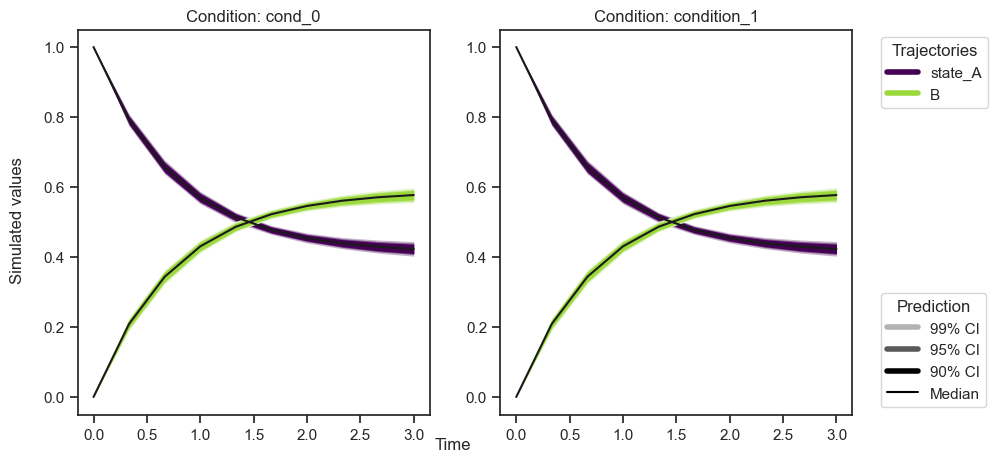

In [12]:
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    condition_ids=["condition_0", "condition_1"],  # `None` for all conditions
    output_ids=["A", "B"],  # `None` for all outputs
)

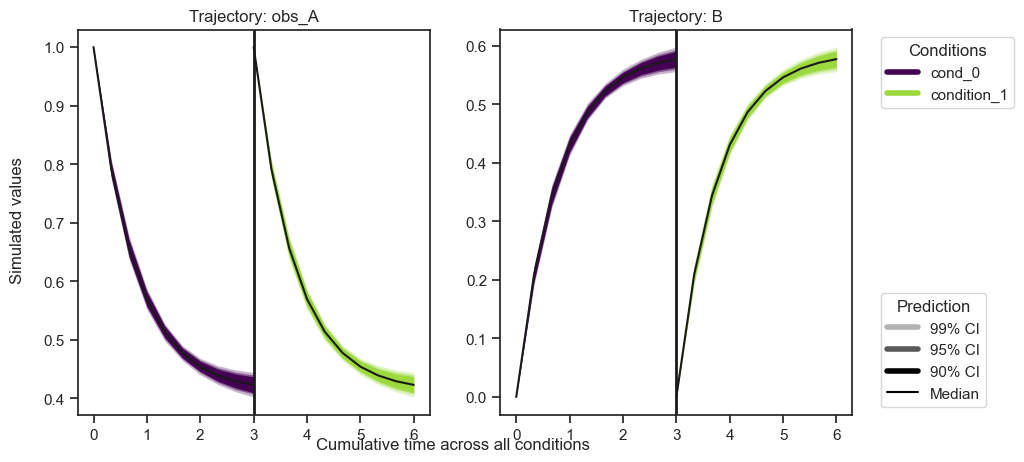

In [13]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
)

Predictions are stored in `ensemble_prediction.prediction_summary`.

### Finding parameter point estimates
Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [14]:
res = optimize.minimize(problem, n_starts=10, filename=None)

100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [16]:
%%capture
res = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=res, filename=None
)
elapsed_time = res.sample_result.time
print("Elapsed time: " + str(round(elapsed_time, 2)))

Elapsed time: 70.66135700000001


When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

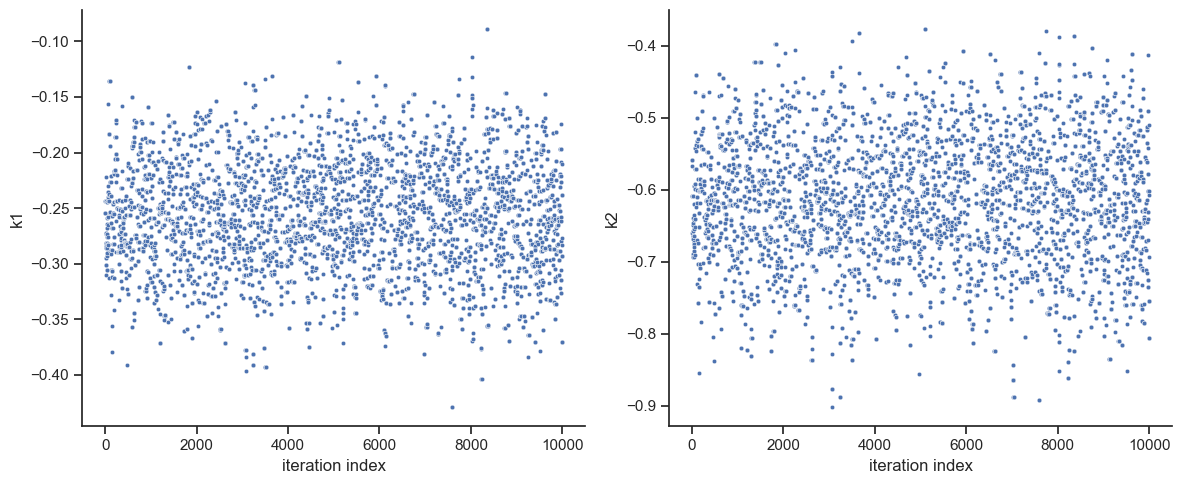

In [17]:
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)

By visual inspection one can see, that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

Geweke burn-in index: 0
Geweke burn-in index: 0


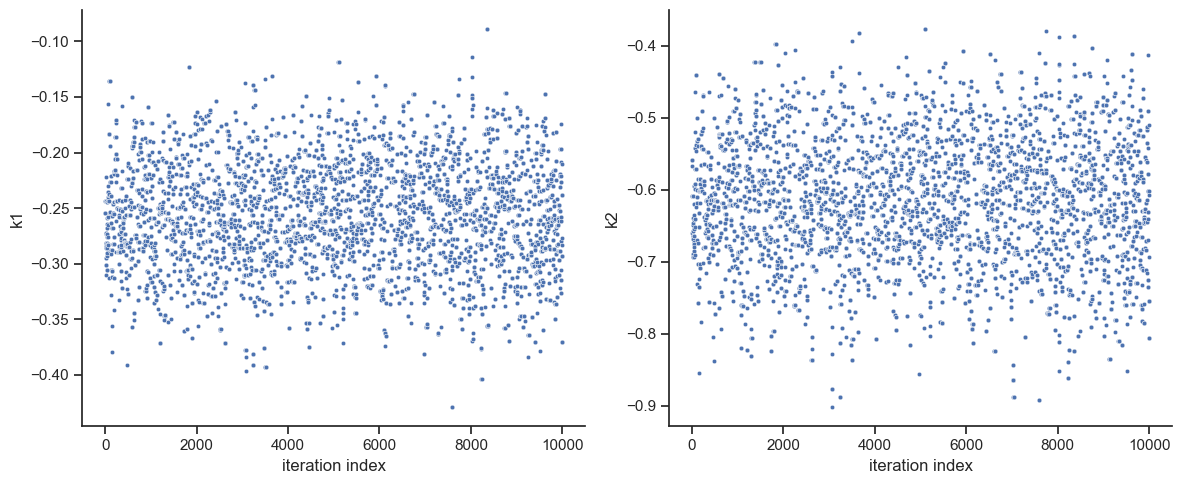

In [18]:
sample.geweke_test(result=res)
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)

In [19]:
sample.effective_sample_size(result=res)
ess = res.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

Estimated chain autocorrelation: 9.392601973748596
Estimated chain autocorrelation: 9.392601973748596
Estimated effective sample size: 962.3191598468054
Estimated effective sample size: 962.3191598468054


Effective sample size per computation time: 13.62


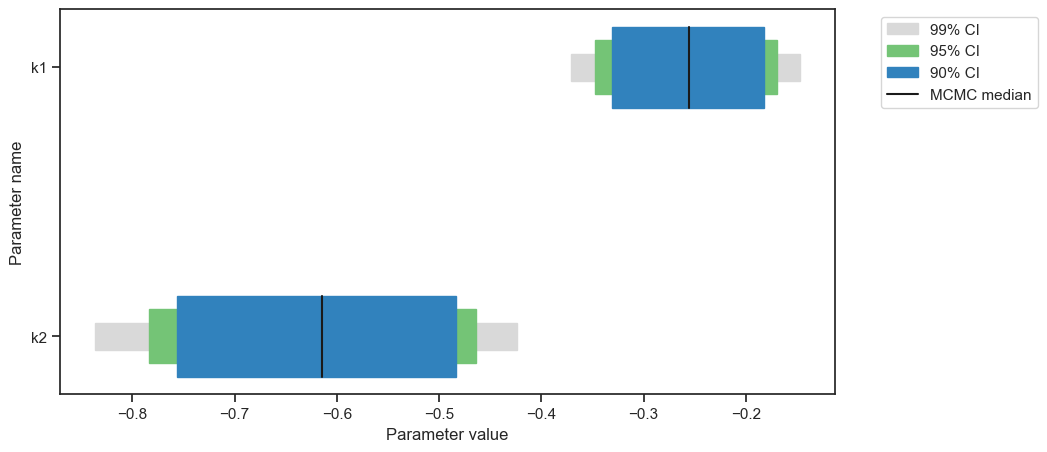

In [20]:
percentiles = [99, 95, 90]
ax = visualize.sampling_parameter_cis(res, alpha=percentiles, size=(10, 5))

In [22]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    res,
    x_names=x_names,
    chain_slice=slice(None, None, 5),
    ensemble_type=EnsembleType.sample,
    lower_bound=res.problem.lb,
    upper_bound=res.problem.ub,
)

ensemble_prediction = ensemble.predict(
    predictor_y, prediction_id=AMICI_Y, engine=engine
)

  0%|          | 0/8 [00:00<?, ?it/s]Executing task 3.
Executing task 2.
Executing task 1.
Executing task 4.
Executing task 0.
Executing task 5.
Executing task 6.
Executing task 7.
100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


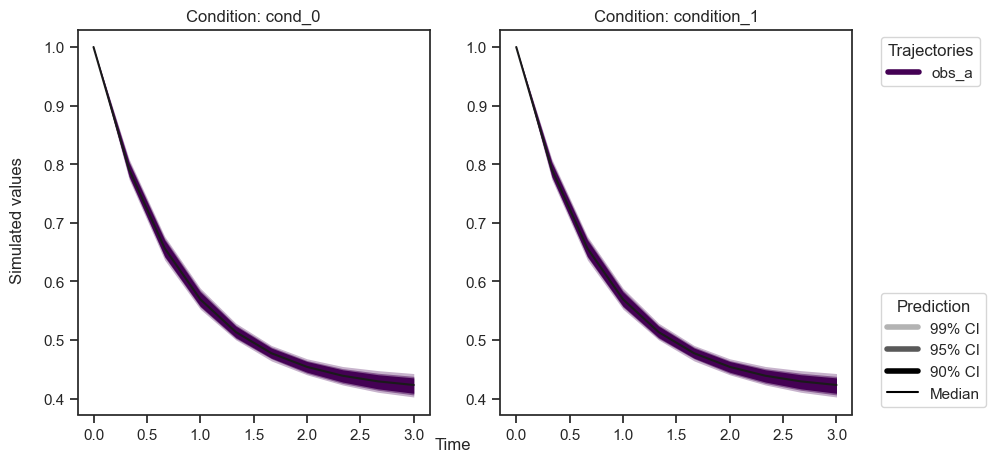

In [23]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
)

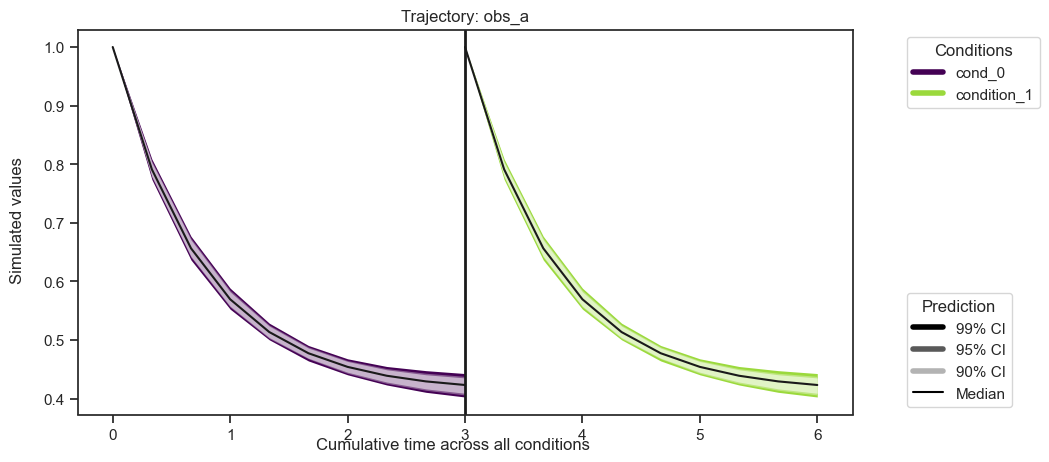

In [24]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
    reverse_opacities=True,
)

Custom timepoints can also be specified, either for each condition
- `amici_objective.set_custom_timepoints(..., timepoints=...)`

or for all conditions
- `amici_objective.set_custom_timepoints(..., timepoints_global=...)`.

Plotting of measurement data (`petab_problem.measurement_df`) is also demonstrated here, which requires correct IDs in the `AmiciPredictor` that align with the observable and condition IDs in the measurement data.

  0%|          | 0/8 [00:00<?, ?it/s]Executing task 2.
Executing task 1.
Executing task 0.
Executing task 3.
Executing task 4.
Executing task 5.
Executing task 6.
Executing task 7.
100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


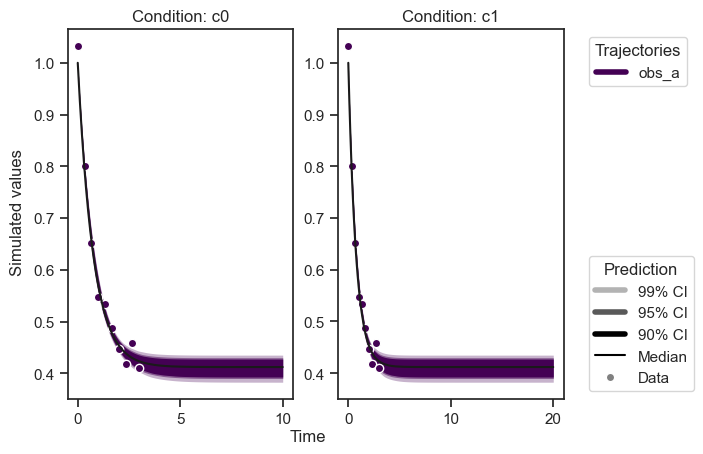

In [25]:
# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 10, 100), np.linspace(0, 20, 200)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
    condition_ids=[edata.id for edata in amici_objective_custom.edatas],
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=petab_problem.measurement_df,
)